In [3]:
# 股票分析增强版 Notebook

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# 美化 Matplotlib / Seaborn 样式
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_theme(style="whitegrid", palette="muted")

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 假设你在Windows上，使用微软雅黑
plt.rcParams['axes.unicode_minus'] = False # 解决负号 '-' 显示为方块的问题

In [4]:
# ===== 1. 读取数据 =====
file_path = "..\\data\\raw\\600519.SH_20150101_20241231_1day_A.csv"  # 你的股票CSV文件
df = pd.read_csv(file_path)

In [5]:
# 日期格式化
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d', errors='coerce')
df = df.sort_values("trade_date").reset_index(drop=True)

# ===== 2. 技术指标计算 =====
# 移动均线
df['MA5'] = df['close'].rolling(5).mean()
df['MA20'] = df['close'].rolling(20).mean()
df['MA60'] = df['close'].rolling(60).mean()

# MACD
short_ema = df['close'].ewm(span=12, adjust=False).mean()
long_ema = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = short_ema - long_ema
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['Hist'] = df['MACD'] - df['Signal']

# RSI (相对强弱指数)
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# 布林带
df['BB_Mid'] = df['close'].rolling(20).mean()
df['BB_Upper'] = df['BB_Mid'] + 2*df['close'].rolling(20).std()
df['BB_Lower'] = df['BB_Mid'] - 2*df['close'].rolling(20).std()

# 涨跌幅
df['pct_change'] = df['close'].pct_change() * 100


In [6]:
# ===== 3. 图表绘制 =====

# --- 3.1 K线 + 均线 ---
fig_candle = go.Figure(data=[go.Candlestick(
    x=df['trade_date'],
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='red',
    decreasing_line_color='green'
)])
# 添加均线
fig_candle.add_trace(go.Scatter(x=df['trade_date'], y=df['MA5'], mode='lines', name='MA5', line=dict(color='orange')))
fig_candle.add_trace(go.Scatter(x=df['trade_date'], y=df['MA20'], mode='lines', name='MA20', line=dict(color='blue')))
fig_candle.add_trace(go.Scatter(x=df['trade_date'], y=df['MA60'], mode='lines', name='MA60', line=dict(color='purple')))
fig_candle.update_layout(title="K线图 + 均线", template="plotly_dark", xaxis_rangeslider_visible=False)
fig_candle.show()

# --- 3.2 成交量 ---
fig_vol = px.bar(df, x='trade_date', y='vol', title="成交量变化", template="plotly_dark")
fig_vol.show()





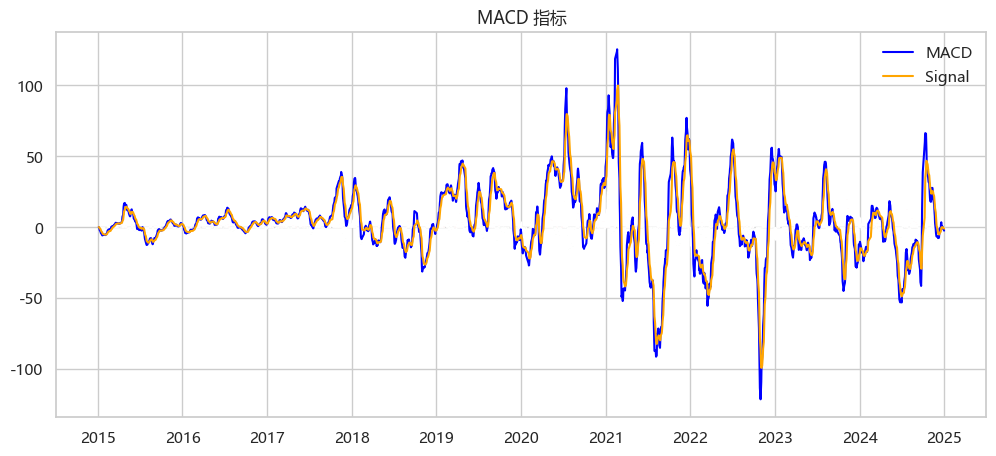

In [7]:
# --- 3.3 MACD ---
plt.figure(figsize=(12,5))
plt.bar(df['trade_date'], df['Hist'], color=np.where(df['Hist']>=0, 'red', 'green'))
plt.plot(df['trade_date'], df['MACD'], label='MACD', color='blue')
plt.plot(df['trade_date'], df['Signal'], label='Signal', color='orange')
plt.title("MACD 指标")
plt.legend()
plt.show()

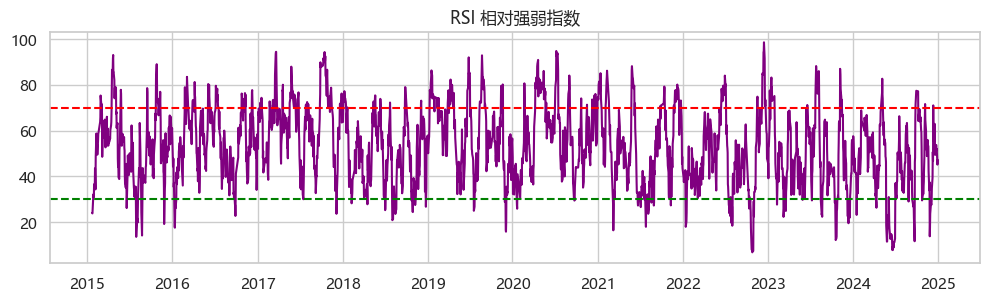

In [8]:
# --- 3.4 RSI ---
plt.figure(figsize=(12,3))
plt.plot(df['trade_date'], df['RSI'], color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title("RSI 相对强弱指数")
plt.show()

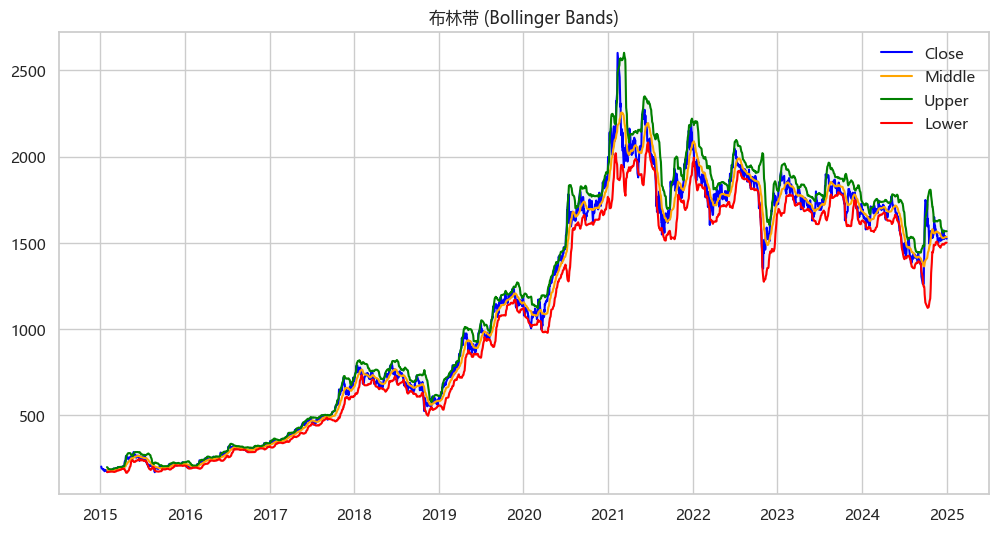

In [9]:
# --- 3.5 布林带 ---
plt.figure(figsize=(12,6))
plt.plot(df['trade_date'], df['close'], label='Close', color='blue')
plt.plot(df['trade_date'], df['BB_Mid'], label='Middle', color='orange')
plt.plot(df['trade_date'], df['BB_Upper'], label='Upper', color='green')
plt.plot(df['trade_date'], df['BB_Lower'], label='Lower', color='red')
plt.fill_between(df['trade_date'], df['BB_Upper'], df['BB_Lower'], color='lightgray', alpha=0.3)
plt.title("布林带 (Bollinger Bands)")
plt.legend()
plt.show()

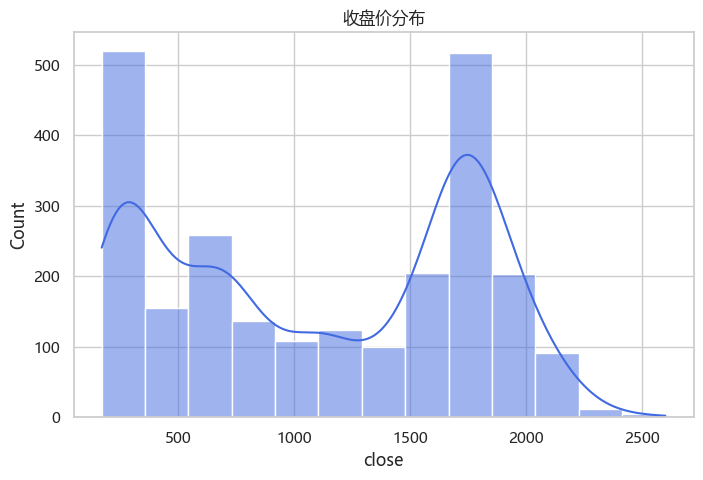

In [10]:
# --- 3.6 收盘价分布 ---
plt.figure(figsize=(8,5))
sns.histplot(df['close'], kde=True, color="royalblue")
plt.title("收盘价分布")
plt.show()

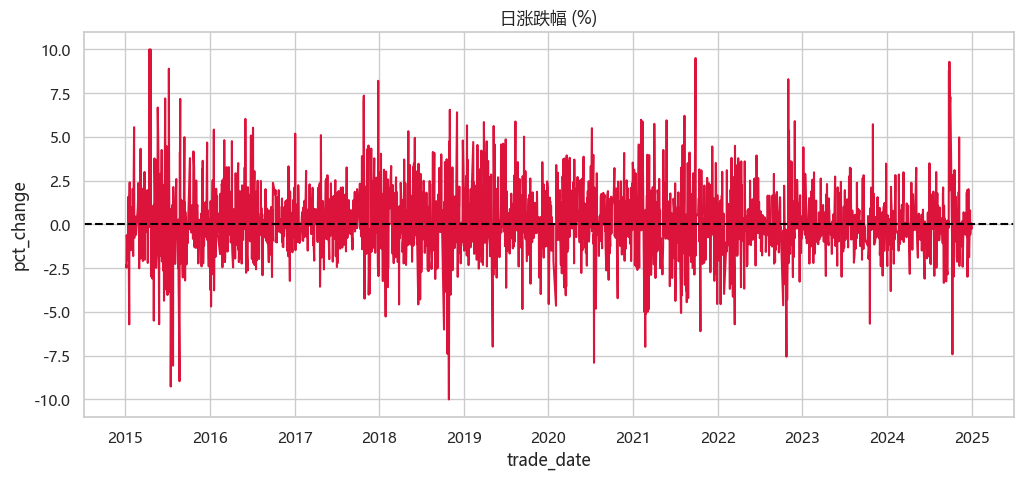

In [11]:
# --- 3.7 涨跌幅时间序列 ---
plt.figure(figsize=(12,5))
sns.lineplot(x='trade_date', y='pct_change', data=df, color="crimson")
plt.axhline(0, color='black', linestyle="--")
plt.title("日涨跌幅 (%)")
plt.show()


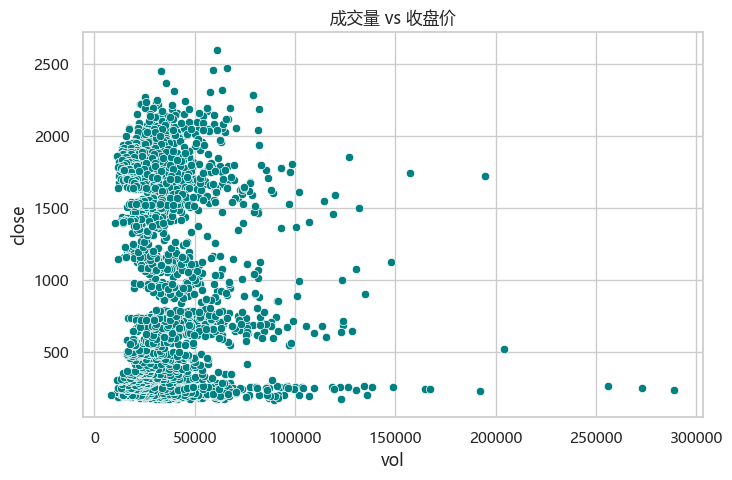

In [12]:
# --- 3.8 成交量与价格关系 ---
plt.figure(figsize=(8,5))
sns.scatterplot(x='vol', y='close', data=df, color="teal")
plt.title("成交量 vs 收盘价")
plt.show()